**Multiclass classification**

Summary: In this lesson, we'll work with the full wildlife dataset, which has eight classes. This is more than the network in the previous notebook can handle. Here we'll build and train a more complicated neural network, called a Convolutional Neural Network, that is meant for working with images. We'll use this network to get the predictions we need for the competition at DrivenData.org.

Objectives:

Read in data with multiple classes
Normalize our data to improve performance
Create a Convolutional Neural Network that works well with images
Train that network to do multiclass classification
Reformat the network predictions to complete the competition
New Terms:

Multiclass


Normalize

Convolution

Max pooling

The Competition

As a reminder, the data we're working with came from a competition at DrivenData.org. The goal of the competition is to build a model that takes an image and classifies what animal is in it. There are seven animals, plus a 'blank' where no animal is present in the image.

So far, we have

Read in image data

Loaded that data in PyTorch

Built a neural network

Used that neural network to do binary classification

We're almost ready for the competition now. We need to expand our network to handle all eight categories. We could do this with the simple network we've already built, but it would perform poorly. Instead, we're going to build a more complex network that's meant for working with images. This is called a Convolutional Neural Network, and involves arranging the neurons in a different pattern.


Once we have built and trained this network, its output will be what the competition is looking for. We'll get our predictions and save them into the requested format.

In [1]:
pip install torchinfo


In [2]:
# 📁 Work with files and paths
import os  # Helps talk to your computer's folders (like opening, saving files)
import sys  # Helps talk to the system, like adding paths or exiting the program

# 🧮 Count things easily
from collections import Counter  # Lets you count how many times items appear in a list

# 📊 Drawing graphs
import matplotlib  # The big toolbox for making graphs and plots
import matplotlib.pyplot as plt  # A smaller tool inside matplotlib, used for making specific graphs (like line or bar charts)

# 🔢 Work with numbers and math
import numpy as np  # Makes it easy to work with lists of numbers, math, and big arrays

# 📋 Work with data like in Excel
import pandas as pd  # Helps load, read, and work with tables of data (like spreadsheets)

# 🖼️ Work with images
import PIL  # Lets you open, edit, and save pictures (stands for Python Imaging Library)

# 🧠 PyTorch – for building and training AI models
import torch  # Main tool to do machine learning and deep learning
import torch.nn as nn  # Lets you build neural networks (nn = neural network)
import torch.optim as optim  # Helps improve (optimize) the model during training

# 🖼️ Prebuilt tools for image tasks
import torchvision  # Gives tools and datasets for working with images in deep learning

# ✅ Check how well the model is doing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix  # Shows how many things the model got right or wrong in a nice table

# 🛠️ Help split and load the data
from torch.utils.data import DataLoader, random_split  # Loads data in small batches + lets you split into training and testing

# 📋 Shows model size and layers
from torchinfo import summary  # Gives a summary of your model (like number of layers, parameters, etc.)

# 🧰 Prebuilt image datasets and transformations
from torchvision import datasets, transforms  # datasets = free image data; transforms = prepare/clean up images

# 🚀 Show progress during training
from tqdm.notebook import tqdm  # Shows a progress bar when training the model (nice and visual)


In [3]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
---
matplotlib version: 3.10.0
pandas version: 2.2.2
PIL version: 11.3.0
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


**We should be running on GPUs, so the device should be cuda.**

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")


Using cpu device.


We'll need to read in our data. Since we'll be using images once again, we'll need to convert them to something our network can understand. To start with, we'll use the same set of transformations we used in the previous notebook.

These transformations are

Convert any grayscale images to RGB format with a custom class

Resize the image, so that they're all the same size (we chose
 x

, but other sizes would work as well)

Convert the image to a Tensor of pixel values

This should result in each image becoming a Tensor of size
 x
 x
. We'll check this once we read in the data.

In [5]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [6]:
transform=transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In the previous notebook, we were working with only two categories. That data was in the data_binary subdirectory. Here we'll work with all eight categories, in the data_multiclass subdirectory. Let's load that data. We will follow the same pattern we used in the last notebook.

**Task 1.4.1: Assign the path to the multi-class training data to train_dir. Then use the ImageFolder tool to open those files and apply our transforms.**

In [7]:
!gsutil cp gs://wqu-cv-course-datasets/project1.tar.gz .


Copying gs://wqu-cv-course-datasets/project1.tar.gz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][631.6 MiB/631.6 MiB]                                                
Operation completed over 1 objects/631.6 MiB.                                    


In [8]:
data_dir = os.path.join("data_p1", "data_multiclass")
train_dir = os.path.join(data_dir,"train")

print("data_dir class:", type(data_dir))
print("Data directory:", data_dir)
print()
print("train_dir class:", type(train_dir))
print("Training data directory:", train_dir)

data_dir class: <class 'str'>
Data directory: data_p1/data_multiclass

train_dir class: <class 'str'>
Training data directory: data_p1/data_multiclass/train


In [9]:
data_dir = 'data_p1/data_multiclass/'
train_dir = os.path.join(data_dir,"train")

print("Will read data from", train_dir)

Will read data from data_p1/data_multiclass/train


**If you downloaded project1.tar.gz, make sure you extracted it like this:**

In [10]:
!tar -xvzf project1.tar.gz

Streaming output truncated to the last 5000 lines.
./data_p1/data_multiclass/train/antelope_duiker/ZJ004383.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ006594.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ007846.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ006580.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ000697.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ013402.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ003611.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ005260.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ002269.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ004618.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ010679.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ015701.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ011201.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ002533.jpg
./data_p1/data_multiclass/train/antelope_duiker/ZJ002255.jpg
./data_p1/data_multiclass/train/an

In [11]:
class_directory=os.listdir(train_dir)
print("There are", len(class_directory), "classes:", class_directory)

There are 8 classes: ['civet_genet', 'antelope_duiker', 'hog', 'bird', 'blank', 'rodent', 'leopard', 'monkey_prosimian']


In [12]:
dataset=datasets.ImageFolder(root=train_dir,transform=transform)

In [13]:
print("Classes:")
print(dataset.classes)
print(f"That's {len(dataset.classes)} classes")
print()
print("Tensor shape for one image:")
print(dataset[0][0].shape)

Classes:
['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']
That's 8 classes

Tensor shape for one image:
torch.Size([3, 224, 224])


In principle, we could work with the data like this. But PyTorch is expecting the data to be broken into batches with a DataLoader. This prevents PyTorch from trying to load all of the files into memory at once, which would cause our notebook to crash. Instead, it loads just a few (the batch_size), works with them, then discards them. Since all the tools are expecting it, we should convert ours. The batch size to work with will depend on our system, but something in the
 to
 range is usually fine. We'll pick
.

In [14]:
batch_size=32
dataset_loader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
first_batch=next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])


As we were reading in the data, we already did some preparation. Our images are all the same shape, and have been converted to tensors. But neural networks tend to perform best with data that has a mean of
 and a standard deviation of
. Data that has that property is called normalized. In our case, that would be the mean and standard deviation of all of the pixels in all of the images.

Let's see what they are for our data. Here's a function that computes the mean and standard deviation for each color channel (red, green, and blue) separately. It takes in a DataLoader and returns the mean and standard deviation of each channel.

In [15]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum +=torch.mean(data,dim=[0,2,3])
        channels_squared_sum +=torch.mean(data**2,dim=[0,2,3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std


**Task 1.4.2: Run the get_mean_std function. on the training data, and save the means and standard deviations to variables mean and std. There should be a value for each color channel, giving us vectors of length
.**

In [16]:
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([0.4788, 0.4926, 0.4834])
Standard deviation: tensor([0.2542, 0.2471, 0.2502])


Now that we have the mean and standard deviation for our images, we can use them to make all our pixels more balanced.

To center the pixels, we subtract the mean from each pixel.

To make the values more consistent, we divide each pixel by the standard deviation.

This helps our model learn better and faster!

Luckily, we don’t have to do this by hand. PyTorch’s transforms.Normalize does it for us automatically.

We just need to:

Give it the 3 mean values (one for Red, one for Green, one for Blue)

And the 3 standard deviation values

Perfect — because that’s exactly what we already calculated!

In [17]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

**Task 1.4.3: Make a new normalized dataset using ImageFolder and a new DataLoader.**

In [18]:
norm_dataset= datasets.ImageFolder(root=train_dir,transform=transform_norm)

norm_loader = DataLoader(dataset=norm_dataset,batch_size=32)

**Task 1.4.4: Use the get_mean_std function to verify the mean and standard deviation are correct in the norm_loader data.**

In [19]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([-0.0001, -0.0002, -0.0003])
Standard deviation: tensor([0.9997, 0.9997, 0.9998])


**Training and Validation Split**

As always, we'll need to divide our data into two parts. We'll train our data on some of our images, and reserve some of them for validation. This will let us see how our model does on images it hasn't seen before. If it makes good predictions on the training data but not on the validation data, we'll know it has overfit.

**Task 1.4.5: Use random_split to create a training dataset with 80% of the data, and a validation dataset with 20% of the data. Be sure to use the normalized data.**

**Channel Statistics Extraction**

In [20]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset,[0.8,0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


In [21]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [22]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions

  0%|          | 0/13191 [00:00<?, ?it/s]

,0
antelope_duiker,1989
bird,1324
blank,1784
civet_genet,1937
hog,780
leopard,1800
monkey_prosimian,1987
rodent,1590


**Task 1.4.6: Create a bar plot from these counts. We did this in the previous notebook.t**

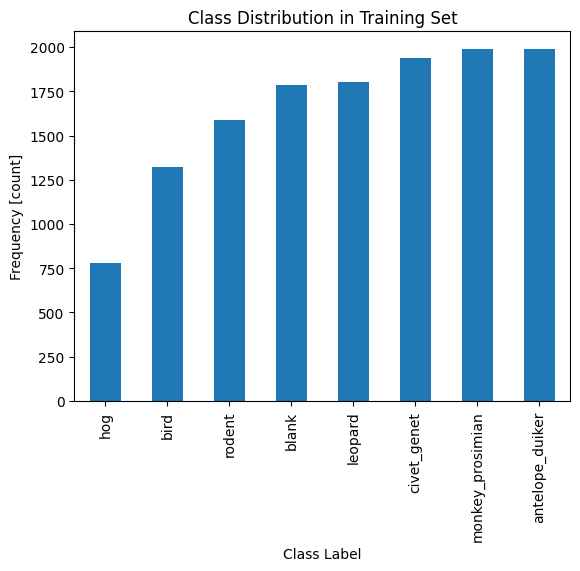

In [23]:
# Create a bar plot from train_class_distribution
train_class_distributions.sort_values().plot(kind="bar")
# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Training Set");

**DataLoader Intialization**
Task 1.4.7: Make the same graph for the validation data.

In [24]:
val_class_distributions = class_counts(val_dataset)

val_class_distributions

  0%|          | 0/3297 [00:00<?, ?it/s]

,0
antelope_duiker,485
bird,317
blank,429
civet_genet,486
hog,198
leopard,454
monkey_prosimian,505
rodent,423


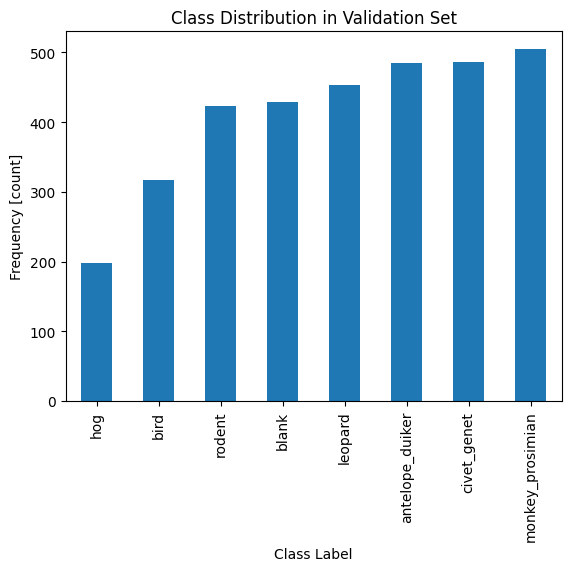

In [25]:
# Get the class distribution
val_class_distributions.sort_values().plot(kind="bar")

# Create a bar plot from train_class_distribution


# Add axis labels and title
plt.xlabel("Class Label")
plt.ylabel("Frequency [count]")
plt.title("Class Distribution in Validation Set");

**Task 1.4.8: Create data loaders for the train and validation sets. Use a batch size of
. Be sure to turn on shuffling for the training set.**

In [26]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


                           #**Multiclass Predictions**

With our data in hand, we're ready to address our task. As in the last notebook, we want a model that will take a picture, and tell us what's in it. But this time, instead of just "hog" or "not hog", we want it to tell us which animal is in the image. This makes it a multiclass classification problem.

Now we're going to have our model give a confidence for each class. This will give us
 values. As before, higher numbers mean that the model is more confident that class is the right answer. A possible output for a single image would be the following.

In [27]:
sample_confidence = torch.tensor([0.13, 0.01, 0.02, 0.12, 0.10, 0.34, 0.16, 0.12])

**Task 1.4.9: Find which animal we should predict, using argmax and the list of classes.**

In [28]:
norm_dataset.classes


['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [29]:
classes=norm_dataset.classes
class_num=torch.argmax(sample_confidence)
prediction=classes[class_num]
print(f"the image is {prediction}")


the image is leopard


#Network Architecture
Now we need a model. We'll build another neural network. The one we built last time was a shallow neural network. This is a network made of a sequence of "dense" or "fully connected" layers. But that's not the only option! You can connect the neurons in different ways, to get different architectures.

The shallow neural network is the "standard", most common one. We could use it for our problem, but to get good accuracy we'd need to add more layers. That network would take a long time to train. We'll be better served by using an architecture meant for images.

A good option, and the one we'll use, is the convolutional neural network (CNN). It consists of a sequence of convolutional and max pooling layers. These are usually followed by some fully connected layers and an output layer.

#Convolution and Max Pooling Layers
The CNN gets its name from the convolutional layers. These layers take in an image, maintaining the 2D structure, and convolve it with a number of kernels. Each kernel will produce a new image. Thankfully, PyTorch will do all the math and tracking for us. Just like we had Linear layers before, we can get a convolutional layer by adding a Conv2D to our model.

As before, we'll use a Sequential model to keep track of how to build things.

In [30]:
model_seq = torch.nn.Sequential()

**Batch Shape Retrival***

In [31]:
conv1=torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),padding=1)
model_seq.append(conv1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Let's also get a single batch of
 images, so we can see what the model is doing.

In [32]:
test_batch = next(iter(train_loader))[0]

**Task 1.4.10: Get the shape of the batch and store it to batch_shape.**

In [33]:
batch_shape = test_batch.shape

print(f"Batch shape: {batch_shape}")

Batch shape: torch.Size([32, 3, 224, 224])


**Task 1.4.11: Get the shape of the output and store it to first_step_shape.**

In [34]:
first_step_out=model_seq(test_batch)

In [35]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
)

Our convolution layers transform images into more images. Ultimately, we're going to need to get down to just our
 output classes. But our convolution has increased the number of pixels! Max pooling will let us shrink our image.

In PyTorch, this is a MaxPool2D layer. The 2D is because we're leaving the channels alone, so it'll max pool on each of our
 channels separately. We'll need to say how big of a patch to reduce, called the kernel again. We'll set it to
 x
, a standard choice. We'll set our stride to
 as well.

In [36]:
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model_seq.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

**Task 1.4.12: Run the current model on the test_batch, and save the output's shape to max_pool_shape.**

In [37]:
max_pool_out = model_seq(test_batch)
max_pool_shape = max_pool_out

print(f"Shape after first max pool: {max_pool_shape}")

Shape after first max pool: tensor([[[[0.0000e+00, 5.3752e-02, 5.8000e-02,  ..., 5.5655e-01,
           5.4616e-01, 5.2306e-01],
          [5.1592e-03, 2.6668e-02, 3.9962e-02,  ..., 1.5981e-01,
           1.5084e-01, 1.2897e-01],
          [6.2435e-03, 3.8940e-02, 3.9796e-02,  ..., 1.7523e-01,
           1.5515e-01, 1.3113e-01],
          ...,
          [0.0000e+00, 4.2949e-03, 5.3413e-02,  ..., 9.6933e-02,
           1.0598e-01, 8.7008e-02],
          [0.0000e+00, 3.7092e-02, 5.8144e-01,  ..., 1.0254e-01,
           1.0295e-01, 8.1297e-02],
          [1.6179e-01, 1.5948e-01, 4.0855e-01,  ..., 9.9120e-02,
           8.7012e-02, 8.7984e-02]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [9.6747e-03, 2.2227e-

**Task 1.4.13: Add a convolution layer taking in our
 channels and outputting
 channels, with a
 x
 kernel and padding of
. Follow that with a ReLU, and a max pool of size
 x
.**

In [38]:
second_conv=torch.nn.Conv2d(in_channels=16,out_channels=32, kernel_size=(3,3),padding=1)
second_pool=torch.nn.MaxPool2d(kernel_size=(2,2),stride=2)
model_seq.append(second_conv)
model_seq.append(torch.nn.ReLU())
model_seq.append(second_pool)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

**Task 1.4.14: Run the current model on the test_batch, and save the output's shape to second_set_shape.**

In [39]:
second_set_out = model_seq(test_batch)
second_set_shape = second_set_out.shape

print(f"Shape after second max pool: {second_set_shape}")

Shape after second max pool: torch.Size([32, 32, 56, 56])


If things went according to plan, you should now have
 channels and a
 x
 image.

You can actually simplify these descriptions. First, you don't have to provide the argument names for most things, IF you provide them in the right order (padding is an exception). Second, for the kernels, if you say
 it knows you mean
 x
 (same for
, etc). Finally, for the max pool you can leave off the stride, it defaults to the size of the kernel. We can use this to make the description of our third layer set more compact. We'll use
 kernels this time.

In [40]:
conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model_seq.append(conv3)
model_seq.append(torch.nn.ReLU())
model_seq.append(max_pool3)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

**Task 1.4.15: Run the current model on the test_batch. Save the output's shape to third_set_shape.**

In [41]:
third_set_out = model_seq(test_batch)
third_set_shape = third_set_out.shape

print(f"Shape after third max pool: {third_set_shape}")

Shape after third max pool: torch.Size([32, 64, 28, 28])


#Finishing the model
We're going to need an output layer with just
 neurons. That's a flat output, without the 3D structure of our images. Conveniently, PyTorch provides a Flatten layer for flattening. Let's add that to our model.

In [42]:
model_seq.append(torch.nn.Flatten())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
)

In [43]:
64 * 28 * 28

50176

**Task 1.4.16: Run the current model on the test_batch. Save the output's shape to flat_shape**

In [44]:
flat_out = model_seq(test_batch)
flat_shape = flat_out.shape

print(f"Shape after flattening: {flat_shape}")

Shape after flattening: torch.Size([32, 50176])


At this point we have a flat input, and can build a normal set of dense layers. You can think of the convolution/max pool layers as having done the image processing. Now we need to do the actual classification. It turns out that dense layers are good at that task.

We could add a single layer and just go straight to our output
 classes. But we'll get better performance by adding a few dense layers, Linear in PyTorch's terminology, first. For these layers, we need to tell it the size of the input, and how many neurons we want in the layer. Since the input is our previous layer, we tell it that size. We'll add a layer of
 neurons.

In [45]:
linear1 = torch.nn.Linear(in_features=50176, out_features=500)

model_seq.append(linear1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
)

**Task 1.4.17: Add the ReLU activation layer**

In [46]:
model_seq.append(torch.nn.ReLU())

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
)

And now we should be getting an output shape from the
 neurons.

In [47]:
linear_out = model_seq(test_batch)
linear_shape = linear_out.shape

print(f"Shape after linear layer: {linear_shape}")

Shape after linear layer: torch.Size([32, 500])


**Task 1.4.18: Add the output dense layer.**

In [48]:
output_layer = torch.nn.Linear(500, 8) # Final output layer

model_seq.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=50176, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=8, bias=True)
)

In [49]:
model_seq(test_batch).shape

torch.Size([32, 8])

#Training the Model
Before we start training, let's put all the model code in one place. This is how you'd do it in practice, to prevent errors.

We have also added Dropout layers after the flattened and linear layers. This helps to prevent overfitting.

In [50]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 8)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

And to make sure PyTorch has the model correct, let's look at the summary.

In [51]:
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

As in the previous notebook, we'll use the cross entropy as our loss function. This will take into account how confident the model is in its answer, as well as whether it was right or wrong. We will also print the accuracy as a human-readable measure.

We'll need to set up our Cross Entropy loss, and an optimizer. We'll also make sure our model is on the GPU.

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [53]:
pip install training

ERROR: Could not find a version that satisfies the requirement training (from versions: none)
ERROR: No matching distribution found for training


In [54]:
from training import predict, train

ModuleNotFoundError: No module named 'training'

In [58]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")


In [61]:
def predict(model, data_loader, device):
    model.eval()
    all_outputs = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Raw scores (logits)
            all_outputs.append(outputs.cpu())  # keep them on CPU

    return torch.cat(all_outputs, dim=0)  # return a single tensor


In [ ]:
model = torch.load("model/trained_model.pth", weights_only=False)

**Task 1.4.20: Calculate the predictions for the validation set.**

In [62]:
probabilities = predict(model,val_loader,device)
predictions = torch.argmax(probabilities, dim=1)

In [64]:
predictions

tensor([0, 0, 0,  ..., 0, 0, 0])

In [60]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

  0%|          | 0/104 [00:00<?, ?it/s]

**Task 1.4.21: Make the same confusion matrix we made last time. You'll need to either move the predictions to cpu or convert them to a list. The labels will be our classes.**

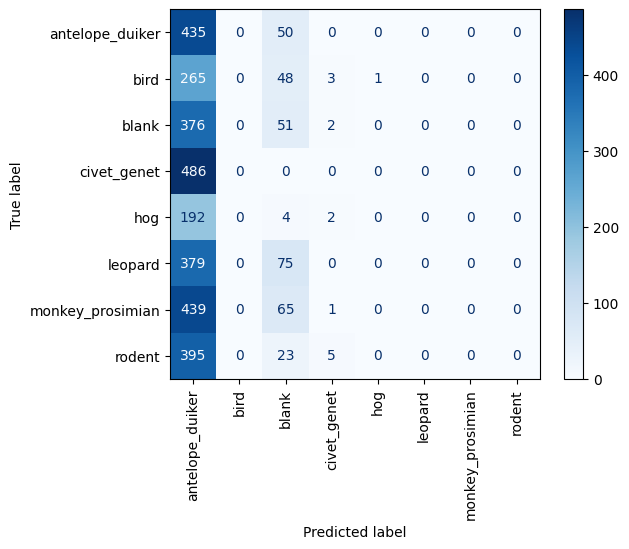

In [63]:
cm = confusion_matrix(targets,predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

#Submission to competition
Now we can use our model to complete the competition. They want our model's confidences for each of the
 classes on a test set. We don't know the answer here (it wouldn't be much of a competition if we did!). We'll need to run each image through our model.

They want the results saved as a csv file, with the columns labeled by the class, and the row index with a special ID. They've given us a file saying how these IDs map to image files. This will be easiest for us to save as a DataFrame.

First, we need to read in the IDs and filenames. All of the test data is in the data_multiclass/test directory, and this ID mapping is in the test_features.csv file.

***Task 1.4.22: Read in the ID mapping csv file with pandas.***

In [65]:
test_dir = os.path.join(data_dir, "test")

# Read the CSV file
id_file_location = os.path.join(test_dir, "test_features.csv")
df_ids = pd.read_csv(id_file_location)

df_ids.head()

,id,filepath
0,ZJ016488,test_features/ZJ016488.jpg
1,ZJ016489,test_features/ZJ016489.jpg
2,ZJ016490,test_features/ZJ016490.jpg
3,ZJ016491,test_features/ZJ016491.jpg
4,ZJ016492,test_features/ZJ016492.jpg


The ID is really just the filename without the .jpg on the end, and all of the images are in the test_features subdirectory of the test directory.

Let's run our model on one of the images. We can get the file location from our DataFrame.

In [66]:
test_image_location = df_ids.iloc[0, 1]
test_image_location

'test_features/ZJ016488.jpg'

**Task 1.4.23: Use PIL to open this image and assign it to test_image.**

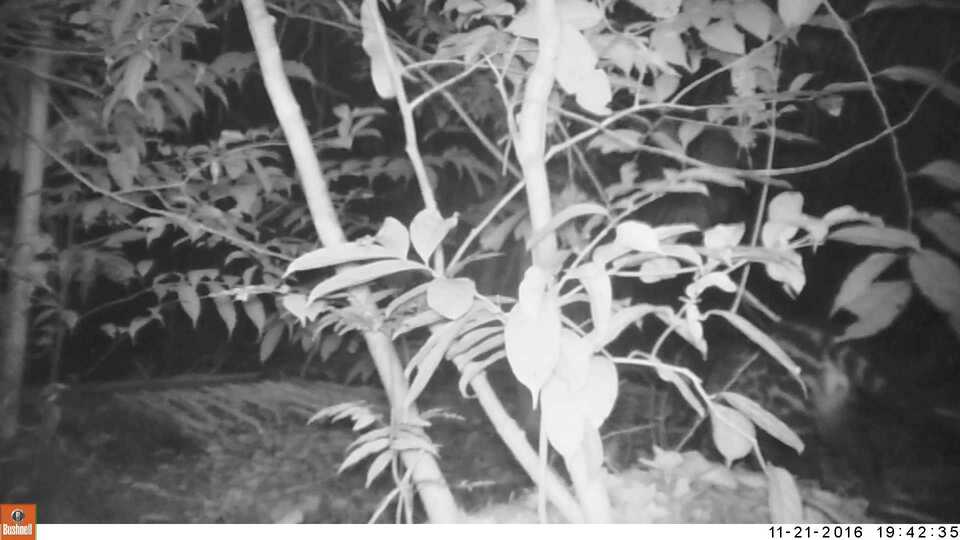

In [67]:
test_image_path = os.path.join(test_dir,test_image_location)
test_image = PIL.Image.open(test_image_path)
test_image

In [68]:
test_image_trans = transform_norm(test_image)
test_image_trans.shape

torch.Size([3, 224, 224])

Almost there. Our model is actually expecting a batch of these. Since we only have one, we'll need to change the tensor to a
 x
 x
 x
. We could do this with reshape, but it's easier to use unsqueeze. unsqueeze is meant for this exact problem. It adds an extra dimension with one element. We just specify which extra dimension we want. In our case, we want the first dimension (i.e. 0) to be the extra one.

In [69]:
test_unsqueeze = test_image_trans.unsqueeze(0)
test_unsqueeze.shape

torch.Size([1, 3, 224, 224])

In [70]:
test_image_cuda = test_unsqueeze.to(device)
test_out = model(test_image_cuda)
test_out

tensor([[ 0.0507, -0.0428,  0.0453,  0.0171, -0.0090, -0.0515, -0.0683, -0.0122]],
       grad_fn=<AddmmBackward0>)

That's the model's predictions, but it's not in the form we expected. We want a set of numbers between 0
 and 1
, that sum to 1
. What we're seeing is the raw output of the last layer. To convert this to the confidences, we need to run it through a SoftMax. This is very much like the logistic or sigmoid you've seen before, except that it works with many inputs. The dim=1 tells it each row is one prediction.

In [71]:
test_softmax = torch.nn.functional.softmax(test_out, dim=1)
test_softmax

tensor([[0.1326, 0.1207, 0.1318, 0.1282, 0.1249, 0.1197, 0.1177, 0.1245]],
       grad_fn=<SoftmaxBackward0>)

Now that we have our numbers, we need to convert to a DataFrame. The predictions are made in the same order as the classes in our dataset. We can't convert a tensor directly to a DataFrame, so we'll convert it to a list first. Then we can set the columns to our classes.

In [72]:
test_df = pd.DataFrame(test_softmax.tolist())
test_df.columns = dataset.classes

test_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.132559,0.120726,0.131835,0.128171,0.124868,0.119678,0.117685,0.124477


In [73]:
image_id = df_ids.iloc[0, 0]
test_df.index = [image_id]

test_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.132559,0.120726,0.131835,0.128171,0.124868,0.119678,0.117685,0.124477


And we're ready to go. Let's put this into a function to make it easier. We'll also add a few things to make PyTorch run faster.

In [74]:
model.to(device)


def file_to_confidence(file_path, image_id):
    image = PIL.Image.open(file_path)
    transformed = transform_norm(image)
    unsqueezed = transformed.unsqueeze(0)
    image_cuda = unsqueezed.to(device)

    model.eval()
    with torch.no_grad():
        model_raw = model(image_cuda)
        confidence = torch.nn.functional.softmax(model_raw, dim=1)

    conf_df = pd.DataFrame(confidence.tolist())
    conf_df.columns = dataset.classes
    conf_df.index = [image_id]

    return conf_df

Let's make sure the function works as expected. We should get the same result as before. Note that the function is expecting the full file path.

**Task 1.4.24: Do it! You can use df_ids.itertuples() to get one row at a time, and pd.concat to assemble many DataFrames into one big one.**

In [75]:
small_dfs = []

for row in df_ids.itertuples():
    image_id = row.id           # this assumes your DataFrame has a column named 'id'
    file_loc = row.filepath     # this assumes your DataFrame has a column named 'filepath'
    filepath = os.path.join(test_dir, file_loc)
    small_dfs.append(file_to_confidence(filepath, image_id))

confidence_df = pd.concat(small_dfs)


In [78]:
confidence_df.head(10)

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.132559,0.120726,0.131835,0.128171,0.124868,0.119678,0.117685,0.124477
ZJ016489,0.130808,0.121694,0.130702,0.127584,0.121828,0.121454,0.123615,0.122315
ZJ016490,0.131937,0.121958,0.131359,0.126723,0.122206,0.119259,0.123611,0.122947
ZJ016491,0.131358,0.121353,0.130745,0.127824,0.122326,0.120935,0.122749,0.122711
ZJ016492,0.129779,0.122242,0.131182,0.129640,0.125123,0.120602,0.119790,0.121642
ZJ016493,0.131359,0.120146,0.128322,0.130222,0.126142,0.120540,0.120328,0.122941
ZJ016494,0.131063,0.120561,0.130015,0.128389,0.122715,0.120759,0.123082,0.123416
ZJ016495,0.131964,0.122401,0.129483,0.127791,0.125247,0.120809,0.120079,0.122226
ZJ016496,0.130727,0.121859,0.130872,0.127169,0.122095,0.121387,0.123667,0.122224
ZJ016497,0.130829,0.122519,0.129992,0.128170,0.124446,0.121295,0.120406,0.122343


In [76]:
confidence_df.to_csv("submission.csv")

We spent a lot of time building and training our model. During training, the model learned the best values (called weights or parameters) to make good predictions.

Now that training is done, we don’t want to lose all that work.

Luckily, PyTorch lets us save everything important:

What the model looks like (its layers)

And the learned values (weights)

Later, we can just load the saved model, and use it again — without training it all over again.

!ls

In [80]:
!ls

data_p1  project1.tar.gz  sample_data  submission.csv


In [81]:
torch.save(model, "/content/submission.csv")

Good work! This was a long one, but we covered a lot of important ideas. We're now able to use PyTorch to classify any number of images, with any number of classes! Here are the key takeaways:

Some preprocessing of our images, or data in general, can help our models.
In multiclass classification, we get a confidence for each of our classes.
Neural networks can have different ways of connecting their neurons, called architectures
The Convolutional Neural Network architecture does well on images
In PyTorch, we can build one by choosing different layers
With a trained model, we can predict the class of an unlabeled image
All together, this let us complete the competition we have been working on. We now have a model that gives us confidences (and thus predictions) on what animals appear in a camera trap image.